<a href="https://colab.research.google.com/github/Shreyabaral/SocialMediaAnalytics/blob/main/youtube_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from googleapiclient.discovery import build
from google.colab import userdata

from tqdm import tqdm

import time
from googleapiclient.errors import HttpError

import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
data= pd.read_csv('vdoLinks.csv')

In [ ]:
data.head()

,youtubeId,movieId,title
0,K26_sDKnvMU,1,Toy Story (1995)
1,3LPANjHlPxo,2,Jumanji (1995)
2,rEnOoWs3FuA,3,Grumpier Old Men (1995)
3,j9xml1CxgXI,4,Waiting to Exhale (1995)
4,ltwvKLnj1B4,5,Father of the Bride Part II (1995)


In [ ]:
data.shape

(25623, 3)

In [3]:
API_KEY = userdata.get('GoogleAPI')


In [4]:
data['youtubeId'].head()

,youtubeId
0,K26_sDKnvMU
1,3LPANjHlPxo
2,rEnOoWs3FuA
3,j9xml1CxgXI
4,ltwvKLnj1B4


In [46]:
def get_youtube_data(video_id):
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # Get video details
    video_response = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        id=video_id
    ).execute()

    if not video_response['items']:
        return None  # Return None if no video found

    video_data = video_response['items'][0]

    # Collect required data
    y_data = {
        'youtubeId': video_id,
        'description': video_data['snippet']['description'],
        'view_count': video_data['statistics'].get('viewCount', 0),
        'like_count': video_data['statistics'].get('likeCount', 0),
        'dislike_count': video_data['statistics'].get('dislikeCount', 0),  # Note: Dislike count is deprecated
        'comment_count': video_data['statistics'].get('commentCount', 0),
        'duration': video_data['contentDetails']['duration'],
        'favorite_count': video_data['statistics'].get('favoriteCount', 0),
        'comments': []
    }

    # Check if comments are disabled
    if int(y_data['comment_count']) > 0:
        comment_response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat='plainText',
            maxResults=100
        ).execute()

        for item in comment_response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            y_data['comments'].append(comment)

    return y_data


In [6]:
get_youtube_data(data['youtubeId'][0]) #checking if the function works

{'video_id': 'K26_sDKnvMU',
 'description': 'Trailer for Toy Story (1995) captured from the The Santa Clause (1994) VHS tape. This tape is labeled 3633 and released in (1994).',
 'view_count': '118049',
 'like_count': '151',
 'dislike_count': 0,
 'comment_count': '0',
 'duration': 'PT1M31S',
 'favorite_count': '0',
 'comments': []}

In [94]:
results = []
count=0
for video_id in tqdm(data['youtubeId'][:50], desc="Processing Videos", unit="video"):

    video_data = get_youtube_data(video_id)
    if video_data:
        results.append(video_data)
        time.sleep(1)
    else:
      count+=1


print(count)
results_df = pd.DataFrame(results)


Processing Videos: 100%|██████████| 50/50 [00:48<00:00,  1.04video/s]

12


In [95]:
#merge data with scraped data
results_df = data.merge(results_df, on='youtubeId', how='inner')


In [96]:
#for the entire dataset #run at the end
'''
results = []

video_ids = data['youtubeId'].tolist()

for i in tqdm(range(0, len(video_ids), 50), desc="Processing Videos", unit="batch"):
    batch_ids = video_ids[i:i + 50]

    try:
        video_data = get_youtube_data(batch_ids)
        results.extend(video_data)  # Extend the results list with the batch
    except HttpError as e:
        if e.resp.status == 403 and "quota" in str(e):
            print("Quota exceeded. Waiting for some time before retrying...")
            time.sleep(10)  # Wait for an hour before retrying
            continue  # Skip to the next iteration
        else:
            print(f"An error occurred: {e}")
'''

'\nresults = []\n\nvideo_ids = data[\'youtubeId\'].tolist()\n\nfor i in tqdm(range(0, len(video_ids), 50), desc="Processing Videos", unit="batch"):\n    batch_ids = video_ids[i:i + 50]\n\n    try:\n        video_data = get_youtube_data(batch_ids)\n        results.extend(video_data)  # Extend the results list with the batch\n    except HttpError as e:\n        if e.resp.status == 403 and "quota" in str(e):\n            print("Quota exceeded. Waiting for some time before retrying...")\n            time.sleep(10)  # Wait for an hour before retrying\n            continue  # Skip to the next iteration\n        else:\n            print(f"An error occurred: {e}")\n'

In [97]:
results_df.head()

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
0,K26_sDKnvMU,1,Toy Story (1995),Trailer for Toy Story (1995) captured from the...,118049,151,0,0,PT1M31S,0,[]
1,3LPANjHlPxo,2,Jumanji (1995),Jumanji Trailer 1995\nDirector: Joe Johnston\n...,198988,286,0,0,PT2M48S,0,[]
2,rEnOoWs3FuA,3,Grumpier Old Men (1995),"The more things change, the more they stay the...",224249,221,0,13,PT1M52S,0,"[Buena película de comedia romántica, 1:36 *GR..."
3,j9xml1CxgXI,4,Waiting to Exhale (1995),Whitney Houston and Angela Bassett star in thi...,437660,0,0,0,PT2M40S,0,[]
4,2GfZl4kuVNI,6,Heat (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1505623,8239,0,681,PT2M28S,0,[The scene in which the lady with curly hair t...


In [98]:
results_df.shape

(38, 11)

In [99]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   youtubeId       38 non-null     object
 1   movieId         38 non-null     int64 
 2   title           38 non-null     object
 3   description     38 non-null     object
 4   view_count      38 non-null     object
 5   like_count      38 non-null     object
 6   dislike_count   38 non-null     int64 
 7   comment_count   38 non-null     object
 8   duration        38 non-null     object
 9   favorite_count  38 non-null     object
 10  comments        38 non-null     object
dtypes: int64(2), object(9)
memory usage: 3.4+ KB


In [100]:
# Convert the 'view_count' column to int
results_df['view_count'] = pd.to_numeric(results_df['view_count'], errors='coerce')
results_df['like_count'] = pd.to_numeric(results_df['like_count'], errors='coerce')

In [101]:
#A list of top 10 videos based on the total views
results_df.sort_values(by='view_count', ascending=False)[:10]

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
37,oiXdPolca5w,50,"Usual Suspects, The (1995)",Who is KEYSER SOZE? a brilliant movie that wil...,4120172,13238,0,677,PT2M25S,0,"[Hungarians, how was the border fence against..."
32,JHIfHL5UgFs,44,Mortal Kombat (1995),Mortal Kombat (1995) Official Trailer - Action...,3548236,18509,0,2199,PT1M48S,0,"[Dang, he did really good🖤💜, 0:25 - does anyon..."
23,15s4Y9ffW_o,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twelve Monkeys movie clips: http://j.mp/1J8Ukt...,3250287,11158,0,1162,PT2M51S,0,"[Good movie, ohhhh ahhh ahhh ohhh~, I am here ..."
36,J5mszOh_Qis,49,When Night Is Falling (1995),Watch the full film here: http://buskfilms.com...,2504815,2791,0,73,PT2M5S,0,[I loved this artistic movie 🫠🫠 I’ve watched l...
11,EJXDMwGWhoA,16,Casino (1995),Casino movie clips: http://j.mp/1JbOasm\nBUY T...,2496000,10220,0,766,PT3M3S,0,"[It's on Tubi, I know Raging Bull, Taxi Driver..."
5,twTksx_lWB4,7,Sabrina (1995),"A remake of a 1954 Billy Wilder romance, this ...",1619161,0,0,0,PT2M50S,0,[]
4,2GfZl4kuVNI,6,Heat (1995),"Director: Michael Mann.\nCast: Al Pacino, Robe...",1505623,8239,0,681,PT2M28S,0,[The scene in which the lady with curly hair t...
22,gA-5nLQCmW8,31,Dangerous Minds (1995),Dangerous Minds Trailer - 1995 Check out red-...,1250954,4967,0,442,PT1M57S,0,[Q\nYou have to RAGE against the dying of the ...
18,RQLVzTtt2Ws,27,Now and Then (1995),Now and Then (1995) Official Trailer 1 - Chris...,972668,7917,0,542,PT2M42S,0,[So glad I grew up with a childhood like this ...
17,UMlYWZgCIgo,25,Leaving Las Vegas (1995),Trailer for Mike Figgis's film,747521,860,0,199,PT2M1S,0,"[Best movie ever, Looks like a pretty picture...."


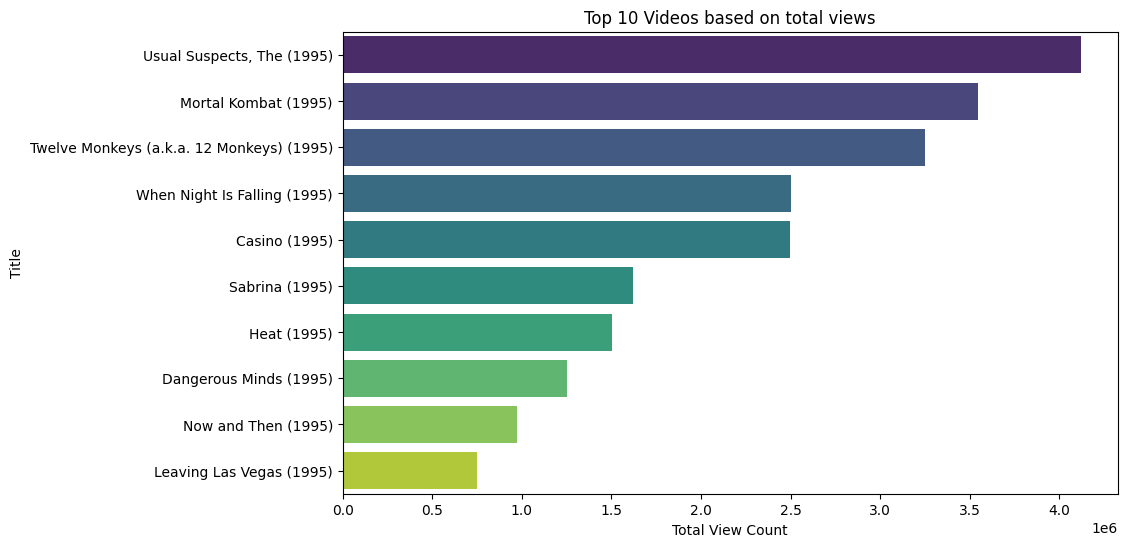

In [141]:
#bar diagram of top 10 videos based on total views
plt.figure(figsize=(10, 6))
sns.barplot(x='view_count', y='title', data=results_df.sort_values(by='view_count', ascending=False)[:10], palette='viridis')
plt.title('Top 10 Videos based on total views')
plt.xlabel('Total View Count')
plt.ylabel('Title')
plt.show()

In [102]:
#A list of bottom 10 videos based on the total views
results_df.sort_values(by='view_count', ascending=False).tail(10)

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
16,gHl-UHu2-lM,24,Powder (1995),Project for Independent Study. Assignment was ...,147089,436,0,57,PT4M3S,0,[Please don't remake the movie they're just go...
0,K26_sDKnvMU,1,Toy Story (1995),Trailer for Toy Story (1995) captured from the...,118049,151,0,0,PT1M31S,0,[]
12,DfqPjRMsRP0,19,Ace Ventura: When Nature Calls (1995),"Africa's the place and Ace is on the case, set...",97602,249,0,14,PT1M59S,0,"[It’s my favorite movie 🎥, Post training, 0:48..."
20,toH1vzAmDBI,29,"City of Lost Children, The (Cité des enfants p...",Cité des enfants perdus - City of Lost Childre...,88593,114,0,14,PT1M15S,0,[This is a perfect representation of what movi...
21,mQf3Ngg2cks,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Shanghai Triad Trailer 1995\nDirector: Zhang Y...,46446,174,0,11,PT2M14S,0,"[Wtf the ending 😢, Very good movie!, Gong Li h..."
26,ccq3f9-lQyM,35,Carrington (1995),Carrington Trailer 1995\nDirector: Christopher...,34078,103,0,13,PT2M32S,0,"[Love this movie....best of all time 🌟⚓🥨🎞🌌, Th..."
8,UrC75wUKoFM,11,"American President, The (1995)",Subscribe to MovieTrailersByVD: http://bit.ly/...,19888,27,0,3,PT2M50S,0,[Why does this have the Little Women (1994) sc...
27,qpQ-CnutDy0,37,Across the Sea of Time (1995),A great film resource for then and now view of...,16823,97,0,23,PT3M42S,0,[Does an IMAX reel of this film exist anywhere...
29,XuHEa7pWAQY,39,Clueless (1995),At a Harold Lloyd Masters Seminar talk at the ...,12703,103,0,11,PT1M47S,0,"[I love Clueless and Amy Heckerling, I hate th..."
24,3_wez2B83ic,33,Wings of Courage (1995),All your favorite Crackle content has made the...,3822,5,0,0,PT1M5S,0,[]


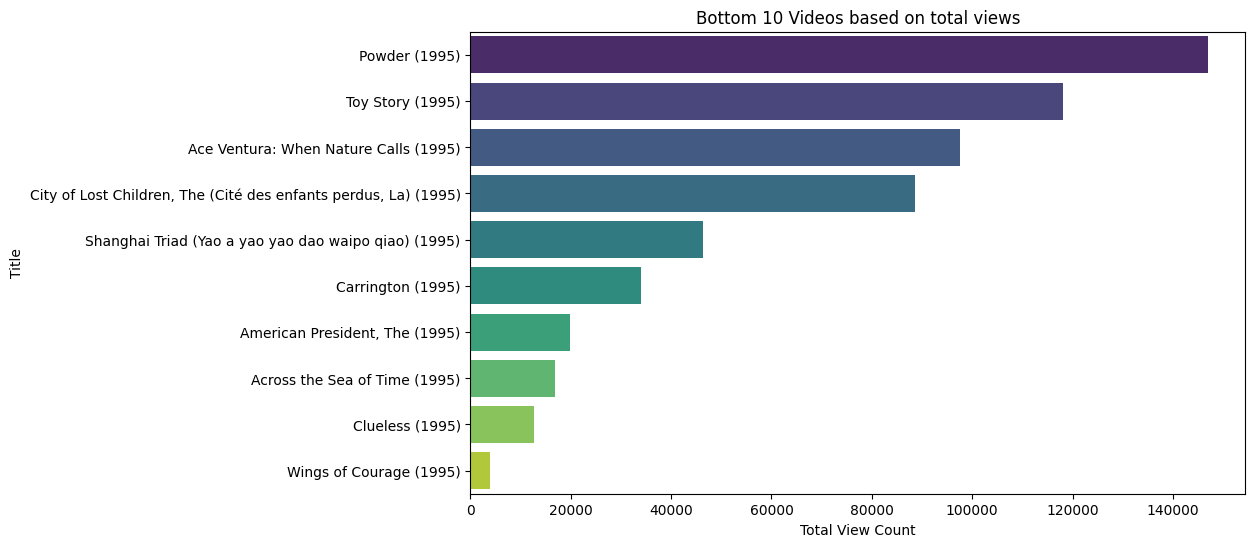

In [139]:
#bar diagram of bottom 10 videos based on total views
plt.figure(figsize=(10, 6))
sns.barplot(x='view_count', y='title', data=results_df.sort_values(by='view_count', ascending=False).tail(10), palette='viridis')
plt.title('Bottom 10 Videos based on total views')
plt.xlabel('Total View Count')
plt.ylabel('Title')
plt.show()

In [103]:
#the most liked video
results_df.sort_values(by='like_count', ascending=False).head(1)

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
32,JHIfHL5UgFs,44,Mortal Kombat (1995),Mortal Kombat (1995) Official Trailer - Action...,3548236,18509,0,2199,PT1M48S,0,"[Dang, he did really good🖤💜, 0:25 - does anyon..."


In [104]:
#the least liked video
results_df.sort_values(by='like_count', ascending=False).tail(3)

,youtubeId,movieId,title,description,view_count,like_count,dislike_count,comment_count,duration,favorite_count,comments
9,tVdn8JH91Dg,12,Dracula: Dead and Loving It (1995),A comic reinvention of the Bela Lugosi classic...,150618,0,0,10,PT2M,0,[The last line in the trailer with Dracula was...
5,twTksx_lWB4,7,Sabrina (1995),"A remake of a 1954 Billy Wilder romance, this ...",1619161,0,0,0,PT2M50S,0,[]
3,j9xml1CxgXI,4,Waiting to Exhale (1995),Whitney Houston and Angela Bassett star in thi...,437660,0,0,0,PT2M40S,0,[]


In [105]:
# Function to convert ISO 8601 duration to total minutes
def convert_duration(duration):
    # Match minutes and seconds using regex
    minutes = int(re.search(r'(\d+)M', duration).group(1)) if 'M' in duration else 0
    seconds = int(re.search(r'(\d+)S', duration).group(1)) if 'S' in duration else 0
    total_minutes = minutes + seconds / 60
    return total_minutes

#Apply the conversion function
results_df['duration'] = results_df['duration'].apply(convert_duration)



In [107]:
#the video with highest duration
results_df.sort_values(by='duration', ascending=False).head(2)['title']

,title
10,Nixon (1995)
16,Powder (1995)


In [108]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [109]:
#Sentiment Analysis using Vader
sid = SentimentIntensityAnalyzer()

def calculate_average_compound_score(texts):
    """
    Calculate the average compound sentiment score for a list of texts using VADER.

    Parameters:
        texts (list of str): A list of text strings to analyze.

    Returns:
        float: The average compound sentiment score for the list of texts.
    """
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    compound_scores = []

    if not texts or len(texts)==0:

        return np.nan
      # Return NaN if the text is empty or None
    else:

      for text in texts:
          sentiment = sia.polarity_scores(text)
          compound_scores.append(sentiment['compound'])  # Append the compound score

    # Calculate the average compound score
    average_compound_score = sum(compound_scores) / len(compound_scores) if compound_scores else 0.0

    return average_compound_score

# Example usage:
average_score = calculate_average_compound_score(results_df['comments'][1])

print(f"Average Compound Score: {average_score}")


results_df['average_compound_score'] = results_df['comments'].apply(calculate_average_compound_score)

Average Compound Score: nan


In [113]:
results_df['average_compound_score'].isna().sum()



8

In [114]:
def categorize_sentiment(compound_score):
    """
    Categorize the sentiment based on the compound score.

    Parameters:
        compound_score (float): The compound sentiment score.

    Returns:
        str: 'pos' for positive, 'neg' for negative, 'neu' for neutral.
    """
    if pd.isna(compound_score):
        return np.nan  # Return NaN if compound_score is NaN
    elif compound_score > 0.05:
        return 'pos'
    elif compound_score < -0.05:
        return 'neg'
    else:
        return 'neu'


results_df['sentiment'] = results_df['average_compound_score'].apply(categorize_sentiment)

In [118]:
results_df[results_df['sentiment']=='pos'].shape #count of positive comments

(29, 13)

In [119]:
results_df[results_df['sentiment']=='neg'].shape #count of negative comments

(1, 13)

In [121]:
results_df[results_df['sentiment']=='neu'].shape #count of neutral comments

(0, 13)

In [127]:
#data with highest positive sentiment scores
highest_pos_score_df= results_df[results_df['sentiment']=='pos'].sort_values(by='average_compound_score', ascending=False).head(10).reset_index(drop=True)





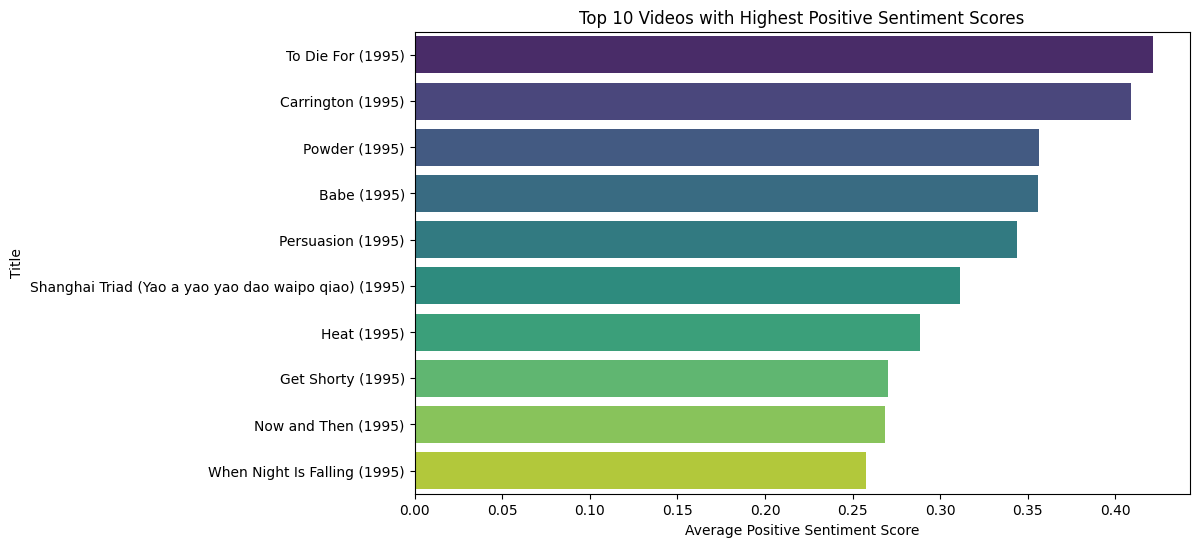

In [140]:
#bar diagram
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='average_compound_score', y='title', data=highest_pos_score_df, hue='title', palette='viridis', legend=False)
plt.title('Top 10 Videos with Highest Positive Sentiment Scores')
plt.xlabel('Average Positive Sentiment Score')
plt.ylabel('Title')
plt.show()